#Predicting Fantasy Football Draftability
### Group JADD: Jonah Lessuk, Aneesh Harwalkar, Dillan Hong, David Doan
### Goal:
Our goal is to create a machine learning model that analyzes fantasy football data from 2017-2023 to generate a rating for each player, indicating their draft worthiness based on pre-proposed factors.

The CSV from the following dataset is required to run this ipynb file:
* "Fantasy Football Data 2017 - 2023" by Gary Bolduc on Kaggle
* https://www.kaggle.com/datasets/gbolduc/fantasy-football-data-2017-2023?select=fantasy_merged_7_17.csv


## Importing necessary libraries

In [ ]:
# Rerun this code cell until all libraries are imported successfully
try:
  import pandas as pd   # https://pandas.pydata.org/docs/
  import numpy as np   # https://numpy.org/doc/
  import seaborn as sns   # https://seaborn.pydata.org/
  import matplotlib.pyplot as plt   # https://matplotlib.org/stable/api/pyplot_summary.html
  from scipy.stats import skew   # https://docs.scipy.org/doc/scipy/reference/stats.html
  from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder, OneHotEncoder   # https://scikit-learn.org/stable/modules/preprocessing.html
  from sklearn.decomposition import PCA   # https://scikit-learn.org/stable/api/sklearn.decomposition.html
  from sklearn.model_selection import train_test_split, KFold   # https://scikit-learn.org/stable/api/sklearn.model_selection.html
  from sklearn.linear_model import LinearRegression, Ridge, Lasso   # https://scikit-learn.org/stable/api/sklearn.linear_model.html
  from sklearn.svm import SVR   # https://scikit-learn.org/stable/modules/svm.html
  from sklearn.tree import DecisionTreeRegressor   # https://scikit-learn.org/stable/api/sklearn.tree.html
  from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor   # https://scikit-learn.org/stable/modules/ensemble.html#
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score   # https://scikit-learn.org/stable/api/sklearn.metrics.html#
  import pickle   # https://docs.python.org/3/library/pickle.html
  import gradio as gr   # https://www.gradio.app/docs
  print("All libraries have been imported successfully...")
except:
  !pip install pandas
  !pip install numpy
  !pip install seaborn
  !pip install matplotlib
  !pip install scipy
  !pip install scikit-learn
  !pip install pickle
  !pip install gradio
  print("Some libraries are not found, installing...")

All libraries have been imported successfully...


#Feature Engineering

In [ ]:
# Importing the CSV file and printing the first few rows
raw_df = pd.read_csv("fantasy_merged_7_17.csv", encoding='latin-1')

# Gets columns with null values and replaces them with 0
null_columns = raw_df.columns[raw_df.isnull().any()].tolist()  # YA and YR have null values
print("Columns with any null values are:",null_columns)
raw_df.fillna(0, inplace=True)

display(raw_df.head())

Columns with any null values are: ['YA', 'YR']


,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,Rec,RecYds,YR,RecTD,Fmb,FL,PPR,PlayerID,PosRk,Year
0,1,Todd Gurley,LAR,RB,23,15,15,0,0,0,...,64,788,12.31,6,5,2,383.3,GurlTo01,1.0,2017
1,2,Russell Wilson,SEA,QB,29,16,16,339,553,3983,...,0,0,0.00,0,14,3,347.9,WilsRu00,1.0,2017
2,3,Le'Veon Bell,PIT,RB,25,15,15,0,0,0,...,85,655,7.71,2,3,2,341.6,BellLe00,2.0,2017
3,4,Alvin Kamara,NOR,RB,22,16,3,0,0,0,...,81,826,10.20,5,1,1,320.4,KamaAl00,3.0,2017
4,5,Antonio Brown,PIT,WR,29,14,14,0,0,0,...,101,1533,15.18,9,4,0,310.3,BrowAn04,1.0,2017


In [ ]:
# Creating initial features and labels
features_df = raw_df.copy().drop(columns=["Rk","PosRk","Year"])
labels_df = raw_df[["PosRk"]]

# Dropping unused feature columns
features_df.drop(columns=["PlayerID","Player","Tm"], inplace=True)
#display(features_df.head())

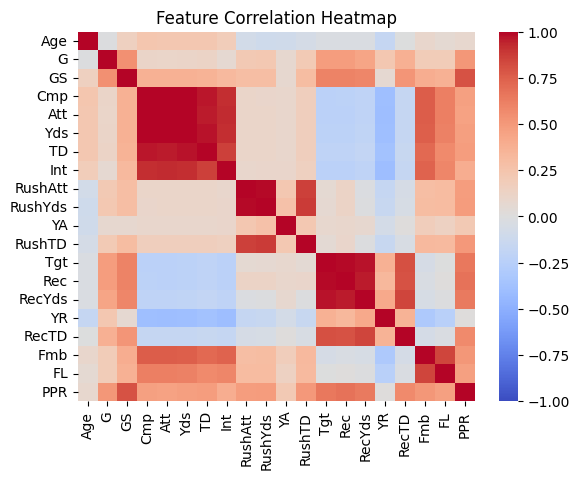

In [ ]:
# Checking to see if features are correlated
numerical_columns = ["Age","G","GS","Cmp","Att","Yds","TD","Int","RushAtt","RushYds",
                     "YA","RushTD","Tgt","Rec","RecYds","YR","RecTD","Fmb","FL","PPR"]
corr_matrix = pd.DataFrame(features_df[numerical_columns]).corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
threshold = 0.8

# Find strongly correlated feature pairs
correlated_pairs = corr_matrix.unstack().reset_index()
correlated_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Filter out weak correlations and self-correlations
strong_correlations = correlated_pairs[
  (correlated_pairs['Correlation'].abs() > threshold) &
  (correlated_pairs['Feature_1'] != correlated_pairs['Feature_2'])
]

# Grouping all the strongly correlated features together
group_correlations = []
for feature_1, feature_2 in zip(strong_correlations['Feature_1'], strong_correlations['Feature_2']):
  exists = False
  ind = None
  for i, group_list in enumerate(group_correlations):
    if feature_1 in group_list:
      exists = True
      ind = i
      break
  if exists:
    if feature_2 not in group_correlations[ind]:
      group_correlations[ind].append(feature_2)
  else:
    group_correlations.append([feature_1, feature_2])

print("Printing all of the strongly correlated feature groups:")
for group in group_correlations:
  print(group)

Printing all of the strongly correlated feature groups:
['GS', 'PPR']
['Cmp', 'Att', 'Yds', 'TD', 'Int']
['RushAtt', 'RushYds', 'RushTD']
['Tgt', 'Rec', 'RecYds', 'RecTD']
['Fmb', 'FL']


## Transforming multicollinear data into PCA components

In [ ]:
clean_df = features_df.copy()

### Encoding Categorical data
# Turning FantPos columns into lists
position_list = clean_df["FantPos"].to_list() # 4 unique positions

# Transforming the above lists into 1-hot encodings
encoding_list = [[el] for el in position_list]
onehot_encoder = OneHotEncoder()
encoded_columns = onehot_encoder.fit_transform(encoding_list).toarray()
onehot_column_names = ['FantPos_' + category for category in onehot_encoder.categories_[0]]
encoded_df = pd.DataFrame(encoded_columns, columns=onehot_column_names)

# Concat the cleaned df and the encoded columns
clean_df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)
clean_df = pd.concat([clean_df, encoded_df], axis=1)
clean_df = clean_df.drop(columns=["FantPos"], axis=1)
clean_df.columns = clean_df.columns.astype(str)


# Keeping a copy of fantasy_features to train models that handle multicollinearity
fantasy_features_multicollinear_df = clean_df.copy()


### Scaling Numerical data
# Decide which columns are distributed normally or skewed using statistical metrics and graphs
#clean_df[["Rec"]].hist(bins=10, edgecolor='black', figsize=(10, 5))
numerical_columns = ["Age","G","GS","Cmp","Att","Yds","TD","Int","RushAtt","RushYds",
                     "YA","RushTD","Tgt","Rec","RecYds","YR","RecTD","Fmb","FL","PPR"]
skewness = clean_df[numerical_columns].apply(skew)
print("Printing the skewness of all the numerical features:")
print(skewness,"\n")

normal_numerical_columns = []
skewed_numerical_columns = []
for ind, skew in enumerate(skewness):
  if skew > 0.5 or skew < -0.5:
    skewed_numerical_columns.append(numerical_columns[ind])
  else:
    normal_numerical_columns.append(numerical_columns[ind])
print("Normally distributed columns:",normal_numerical_columns)
print("Skewed columns:",skewed_numerical_columns,"\n")

# Scaling the features according to their distribution
skew2normal = PowerTransformer(method='yeo-johnson').fit_transform(clean_df[skewed_numerical_columns])
skew2standard = StandardScaler().fit_transform(skew2normal)

# Replacing numerical columns with their scaled values
clean_df[skewed_numerical_columns] = skew2standard
#display(clean_df.head())


# Features and labels cleaned and ready
fantasy_features_df = clean_df
fantasy_labels_df = labels_df


Printing the skewness of all the numerical features:
Age        1.250696
G         -0.690616
GS         0.696971
Cmp        3.994980
Att        3.915833
Yds        4.033851
TD         4.617195
Int        4.255389
RushAtt    2.971415
RushYds    3.108981
YA         1.862675
RushTD     3.755773
Tgt        1.526440
Rec        1.587321
RecYds     1.905831
YR         0.728506
RecTD      2.273740
Fmb        3.377022
FL         3.270358
PPR        1.323142
dtype: float64 

Normally distributed columns: []
Skewed columns: ['Age', 'G', 'GS', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'RushAtt', 'RushYds', 'YA', 'RushTD', 'Tgt', 'Rec', 'RecYds', 'YR', 'RecTD', 'Fmb', 'FL', 'PPR'] 



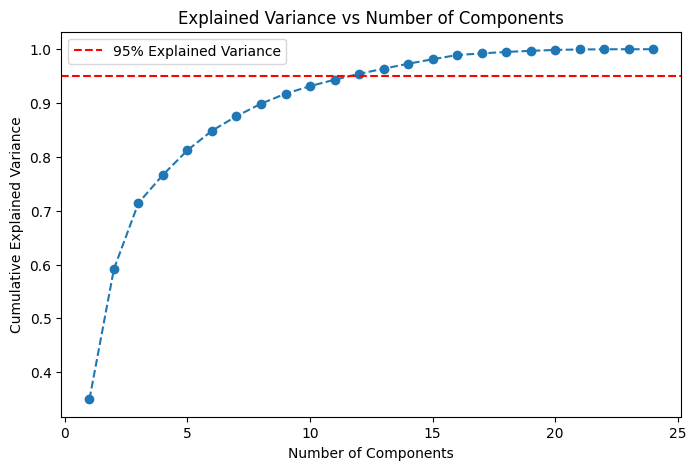


Number of components for 95% variance: 12


In [ ]:
# Fit PCA
pca = PCA()
pca.fit(fantasy_features_df)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# Find the number of components for 95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components for 95% variance: {n_components}")

In [ ]:
pca = PCA(n_components=n_components)
fantasy_features_pca_df = pca.fit_transform(fantasy_features_df)

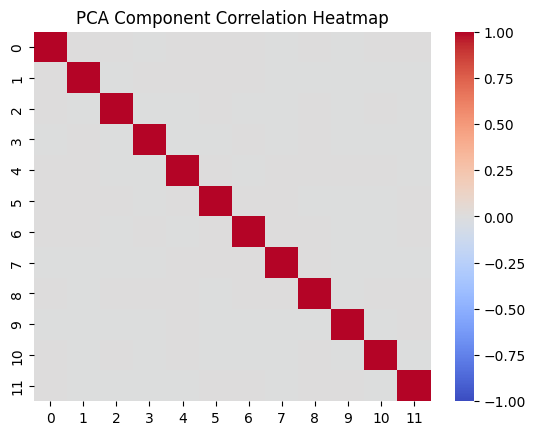

In [ ]:
# Checking to see if features are correlated
pca_corr_matrix = pd.DataFrame(fantasy_features_pca_df).corr()
sns.heatmap(pca_corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("PCA Component Correlation Heatmap")
plt.show()

##Splitting data for K-fold cross validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

def creating_kfold_data(features, k):
  # Extracting the test data
  labels = fantasy_labels_df.to_numpy()
  _x, x_test, _y, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)

  kfold_spliiter = KFold(n_splits=k)

  folds_data = []
  fold = 1
  for train_index, validation_index in kfold_spliiter.split(_x):
    x_train , x_valid = _x[train_index,:],_x[validation_index,:]
    y_train , y_valid = _y[train_index,:] , _y[validation_index,:]
    print (f"Fold {fold} training / validation data shape = {x_train.shape,y_train.shape} / {x_valid.shape,y_valid.shape}")
    fold+=1
    folds_data.append((x_train,y_train,x_valid,y_valid))
  return folds_data

# Set number of folds to 10
k = 10

print("Making k-fold data for PCA")
pca_folds_data = creating_kfold_data(fantasy_features_pca_df, k)
print("\nMaking k-fold data for multicollinear")
multicollinear_folds_data = creating_kfold_data(fantasy_features_multicollinear_df.to_numpy(), k)

Making k-fold data for PCA
Fold 1 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))
Fold 2 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))
Fold 3 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))
Fold 4 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))
Fold 5 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))
Fold 6 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))
Fold 7 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))
Fold 8 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))
Fold 9 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))
Fold 10 training / validation data shape = ((2439, 12), (2439, 1)) / ((271, 12), (271, 1))

Making k-fold data for multicollinear
Fold 1 training / validation data

# Initializing chosen models


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Initializing all models
## Linear Regression models
linreg = LinearRegression()
linreg_ridge = Ridge(alpha=0.1, max_iter=150000)
linreg_lasso = Lasso(alpha=0.1, max_iter=150000)
## Support Vector Regression models
svr_linear = SVR(kernel='linear', C=4, epsilon=0.1)
svr_poly = SVR(kernel='poly', degree=3)
svr_rbf = SVR(kernel='rbf', C=15, gamma=0.1, epsilon=1)
## Decision Tree Regression models
dtreg = DecisionTreeRegressor(random_state=42, max_depth=5)
rfreg = RandomForestRegressor(random_state=42)
gbreg = GradientBoostingRegressor(random_state=42, max_depth=3)

# Storing all models in a dictionary
all_models = {"Linear Regression":linreg,
              "Linear Ridge Regression":linreg_ridge,
              "Linear Lasso Regression":linreg_lasso,
              "SVR with linear kernel":svr_linear,
              "SVR with polynomial kernel":svr_poly,
              "SVR with RBF kernel":svr_rbf,
              "Decision Tree":dtreg,
              "Random Forest":rfreg,
              "Gradient Boosting":gbreg}


# Training and evaluating the models

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_validation_mse = 0
best_model_name = ""
best_model = None
y_val = None
best_y_pred = None

handle_multicollinear = ["Linear Ridge Regression", "Linear Lasso Regression",
                         "Decision Tree", "Random Forest", "Gradient Boosting"]  # These models can handle data with high multicollinearity

# Iterate over all models
for model_name in all_models.keys():

    print (f"Evaluating   {model_name}   ...")
    model = all_models[model_name]

    # Let's store training and validation MSE for all folds
    mse_for_all_folds = []
    mae_for_all_folds = []
    r2_for_all_folds = []

    # Using the correct fold data depending on using PCA or not
    if model_name in handle_multicollinear:
        folds_data = multicollinear_folds_data
    else:
        folds_data = pca_folds_data

    #Iterate over all folds
    for i, fold in enumerate(folds_data):
        x_train, y_train, x_valid, y_valid = fold
        y_train, y_valid = y_train.flatten(), y_valid.flatten()

        # Train the model
        _ = model.fit(x_train,y_train)

        # Evluate model on training data
        y_pred_train = model.predict(x_train)

        # Evaluate the model on validation data
        y_pred_valid = model.predict(x_valid)

        # Compute training MSE
        #print (y_pred_train.shape)
        #print (y_train.shape)
        #print (y_pred_valid.shape)
        #print (y_valid.shape)
        train_mse = mean_squared_error(y_pred_train , y_train)
        train_mae = mean_absolute_error(y_pred_train , y_train)
        train_r2 = r2_score(y_pred_train , y_train)

        # Compute validation errors
        valid_mse = mean_squared_error(y_pred_valid , y_valid)
        valid_mae = mean_absolute_error(y_pred_valid , y_valid)
        valid_r2 = r2_score(y_pred_valid , y_valid)

        # Storing errors across k folds
        mse_for_all_folds.append((train_mse,valid_mse))
        mae_for_all_folds.append((train_mae,valid_mae))
        r2_for_all_folds.append((train_r2,valid_r2))

    #average training errors across k folds
    avg_training_mse = sum(item[0] for item in mse_for_all_folds)/k
    avg_training_mae = sum(item[0] for item in mae_for_all_folds)/k
    avg_training_r2 = sum(item[0] for item in r2_for_all_folds)/k

    #average validation errors across k folds
    avg_validation_mse = sum(item[1] for item in mse_for_all_folds)/k
    avg_validation_mae = sum(item[1] for item in mae_for_all_folds)/k
    avg_validation_r2 = sum(item[1] for item in r2_for_all_folds)/k

    print (f"Average MSE on training / validation data = {avg_training_mse} / {avg_validation_mse}")
    print (f"Average MAE on training / validation data = {avg_training_mae} / {avg_validation_mae}")
    print (f"Average R2 on training / validation data = {avg_training_r2} / {avg_validation_r2}")

    # Select best model based on average validation MSE
    if best_model is None:
        best_validation_mse = avg_validation_mse
        best_model_name = model_name
        best_model = model
        y_val = y_valid
        best_y_pred = y_pred_valid
    if avg_validation_mse < best_validation_mse:
        best_validation_mse = avg_validation_mse
        best_model_name = model_name
        best_model = model
        y_val = y_valid
        best_y_pred = y_pred_valid
    print (f"-----------------------------------")

print (f"Best model for the task is   {best_model_name}   which offers the validation MSE of {best_validation_mse}")

Evaluating   Linear Regression   ...
Average MSE on training / validation data = 447.1080153089607 / 453.76433658888766
Average MAE on training / validation data = 15.997263477422027 / 16.08469825550562
Average R2 on training / validation data = 0.8261596287655715 / 0.823160557367129
-----------------------------------
Evaluating   Linear Ridge Regression   ...
Average MSE on training / validation data = 320.3170458564022 / 326.6109766957216
Average MAE on training / validation data = 13.675084428341421 / 13.79571543482972
Average R2 on training / validation data = 0.8812796599790621 / 0.8783283548954088
-----------------------------------
Evaluating   Linear Lasso Regression   ...
Average MSE on training / validation data = 321.0676559110308 / 327.0593881393901
Average MAE on training / validation data = 13.703613303171366 / 13.815128979378347
Average R2 on training / validation data = 0.8796625037930935 / 0.8767586671207603
-----------------------------------
Evaluating   SVR with li

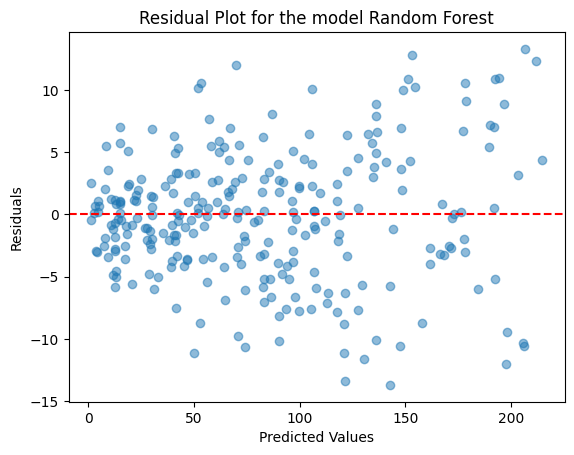

In [ ]:
# Residuals
residuals = y_valid - y_pred_valid

# Residual plot
plt.scatter(y_pred_valid, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title(f"Residual Plot for the model {best_model_name}")
plt.show()

# Feature selection

## Getting feature_importances_ from the Random Forest model

       Feature  Importance
19         PPR    0.690810
23  FantPos_WR    0.228029
21  FantPos_RB    0.064604
22  FantPos_TE    0.006430
20  FantPos_QB    0.003588
14      RecYds    0.000893
1            G    0.000640
13         Rec    0.000618
0          Age    0.000600
12         Tgt    0.000570
8      RushAtt    0.000566
15          YR    0.000519
9      RushYds    0.000358
5          Yds    0.000352
2           GS    0.000308
10          YA    0.000306
4          Att    0.000201
3          Cmp    0.000182
17         Fmb    0.000152
18          FL    0.000091
16       RecTD    0.000087
6           TD    0.000042
11      RushTD    0.000028
7          Int    0.000026 



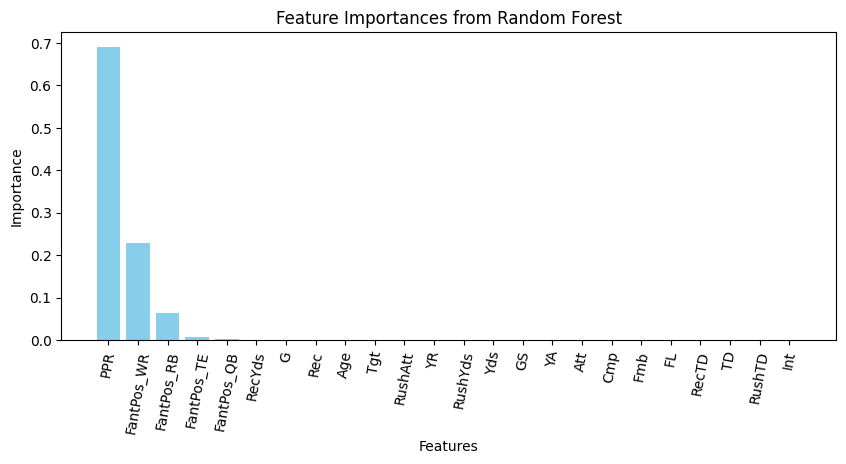

In [ ]:
importances = best_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': fantasy_features_multicollinear_df.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances,"\n")

plt.figure(figsize=(10, 4))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.xticks(rotation=80)
plt.show()

## Ablation testing on the Gradient Boosting model

In [ ]:
def perform_k_fold_error(ablated_features, model_name):
  # Getting the model used for ablation testing
  model = all_models[model_name]

  # Split the data into 80% train and 20% test
  x_, x_test, y_, y_test = train_test_split(ablated_features, fantasy_labels_df, test_size=0.20, random_state=42)
  x_, x_test, y_, y_test = x_.to_numpy(), x_test.to_numpy(), y_.to_numpy(), y_test.to_numpy()

  # Specify the k-fold
  k = 10
  kfold_splitter = KFold(n_splits=k)

  # Initialize error accumulators
  average_error_mse = 0
  average_error_mae = 0
  average_error_r2 = 0
  i = 1

  for train_index, validation_index in kfold_splitter.split(x_):
      x_train, x_valid = x_[train_index], x_[validation_index]
      y_train, y_valid = y_[train_index], y_[validation_index]

      #print(f"Fold {i} training data shape = {(x_train.shape, y_train.shape)}")
      #print(f"Fold {i} validation data shape = {(x_valid.shape, y_valid.shape)}")

      # Train the models
      model.fit(x_train, y_train.ravel())

      # Evaluate models on validation data
      y_pred_valid_model_1 = model.predict(x_valid)

      # Compute MSE for each model
      mse = mean_squared_error(y_valid, y_pred_valid_model_1)
      mae = mean_absolute_error(y_valid, y_pred_valid_model_1)
      r2 = r2_score(y_valid, y_pred_valid_model_1)

      # Accumulate errors
      average_error_mse += mse
      average_error_mae += mae
      average_error_r2 += r2
      i += 1

  # Calculate average error
  average_error_mse /= k
  average_error_mae /= k
  average_error_r2 /= k

  print(f"Average {k}-fold error for model {model_name} ( MSE / MAE / R2 ) = {average_error_mse} / {average_error_mae} / {average_error_r2}")
  return average_error_mse

# Groups the features for ablation testing, where features are grouped based on collinearity (correlation) or their one-hot encoding representations
#abl_feature_names = list(fantasy_features_df.columns.tolist())
#abl_groupped_features = group_correlations[:]
#abl_groupped_features.append(onehot_column_names)
#for feature in abl_feature_names:
#  exists = False
#  for group in abl_groupped_features:
#    if feature in group:
#      exists = True
#      break
#  if exists is False:
#    abl_groupped_features.append([feature])

abl_groupped_features = fantasy_features_df.columns.tolist()

# Performing the ablation testing by removing each group of features
abl_errors = []
for i in range(len(abl_groupped_features)):
  ablat = fantasy_features_df.copy()
  # Removing the feature for ablation testing
  feature_name = abl_groupped_features[i]
  print (f"Removing feature {feature_name}")
  feature_ablated = ablat.drop(columns=feature_name)

  # Running kfold without the feature
  abl_errors.append(perform_k_fold_error(feature_ablated, "Gradient Boosting"))
  print (f"-----------------------------------")

Removing feature Age
Average 10-fold error for model Gradient Boosting ( MSE / MAE / R2 ) = 22.79486629064443 / 3.7599620591217358 / 0.9924321787013003
-----------------------------------
Removing feature G
Average 10-fold error for model Gradient Boosting ( MSE / MAE / R2 ) = 23.05198106754629 / 3.785873956359427 / 0.9923494048370193
-----------------------------------
Removing feature GS
Average 10-fold error for model Gradient Boosting ( MSE / MAE / R2 ) = 22.595107202914352 / 3.7413643051034216 / 0.9924983872361649
-----------------------------------
Removing feature Cmp
Average 10-fold error for model Gradient Boosting ( MSE / MAE / R2 ) = 22.81539975485796 / 3.763316745606109 / 0.9924265439342047
-----------------------------------
Removing feature Att
Average 10-fold error for model Gradient Boosting ( MSE / MAE / R2 ) = 22.926377418611686 / 3.7682314026209425 / 0.9923892670391474
-----------------------------------
Removing feature Yds
Average 10-fold error for model Gradient B

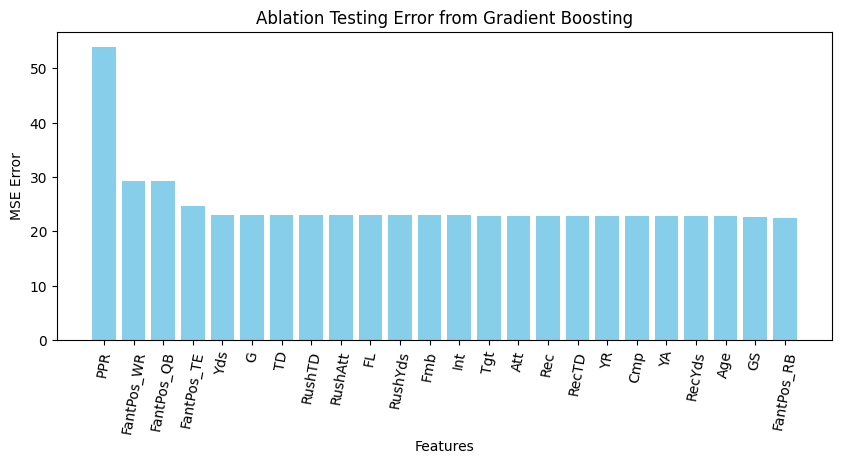

In [ ]:
abl_feature_rankings = pd.DataFrame({
    'Feature': abl_groupped_features,
    'Error': abl_errors
}).sort_values(by='Error', ascending=False)

plt.figure(figsize=(10, 4))
plt.bar(abl_feature_rankings['Feature'], abl_feature_rankings['Error'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('MSE Error')
plt.title('Ablation Testing Error from Gradient Boosting')
plt.xticks(rotation=80)
plt.show()

# Saving and exporting our models

In [ ]:
def save_model(model_name):
  filename = model_name.replace(" ", "_")+".pkl"
  with open(filename, 'wb') as file:
    pickle.dump(all_models[model_name], file)
  print(f"Model saved to {filename}")

save_model(best_model_name)

Model saved to Random_Forest.pkl


# Demo

In [ ]:
# Load the pre-trained model
with open("Random_Forest.pkl", "rb") as model_file:
  best_model = pickle.load(model_file)

# Define numerical and position columns
numerical_columns = ["Age", "G", "GS", "Cmp", "Att", "Yds", "TD", "Int",
                     "RushAtt", "RushYds", "YA", "RushTD", "Tgt", "Rec",
                     "RecYds", "YR", "RecTD", "Fmb", "FL", "PPR"]
name_columns = ["Age", "G - Games Played", "GS - Games Started", "Cmp - Completed Passes", "Att - Attempts", "Yds - Total Yards", "TD - Touchdowns", "Int - Interceptions",
                     "RushAtt - Rushing Attempts", "RushYds - Rushing Yards", "YA - Yards per Attempt", "RushTD - Rushing Touchdowns", "Tgt - Targets", "Rec - Receptions",
                     "RecYds - Receiving Yards", "YR - Yards per Reception", "RecTD - Receiving Touchdowns", "Fmb - Fumbles", "FL - Fumbles Lost", "PPR - Points per Reception"]
positions = ["Quarterback", "Running Back", "Tight End", "Wide Receiver"]
encoded_positions = [f"FantPos_{pos}" for pos in positions]  # ["FantPos_QB", "FantPos_RB", ...]

# Fit preprocessors
onehot_encoder = OneHotEncoder(sparse_output=False).fit(np.array(positions).reshape(-1, 1))

# Prediction function
def predict_fantasy(*inputs):
  print(inputs)
  # Replacing all empty values with 0 or a default value
  full_inputs = [0 if x is None else x for x in inputs[:-1]]
  if inputs[-1] is None:
    full_inputs.append("QB")
  else:
    full_inputs.append(inputs[-1])
  inputs = full_inputs

  try:
    # Separate numerical inputs and position
    numerical_inputs = np.array(inputs[:-1]).reshape(1, -1)
    position_input = inputs[-1]

    # Encode position as "FantPos_*"
    position_encoded = np.zeros(len(encoded_positions))
    position_encoded[positions.index(position_input)] = 1
    position_encoded = position_encoded.reshape(1, -1)  # Ensure it's 2D

    # Combine scaled numerical inputs and encoded position
    combined_inputs = np.hstack([numerical_inputs, position_encoded])

    # Predict using the model
    prediction = best_model.predict(combined_inputs)
    print(combined_inputs)
    return prediction[0]
  except Exception as e:
    return f"Error: {str(e)}"

data_df = pd.read_csv("fantasy_merged_7_17.csv", encoding='latin-1')

# Gradio Interface
feature_inputs = [gr.Slider(0, (((data_df[col].max() + 99) // 100) * 100), step=1, label=namecol, interactive=True) for col, namecol in zip(numerical_columns, name_columns)] + [gr.Dropdown(choices=positions, label="Position")]
demo = gr.Interface(fn=predict_fantasy,
                    inputs=feature_inputs,
                    outputs=[gr.Number(label="Position Ranking")],
                    title="Fantasy Football Rank Predictor",
                    description="Provide key player stats and position to predict their positional rank.")

# Launch the Gradio demo
demo.launch(debug=False)
